## Ноутбук с симуляцией ATL

Если используется GPU, выставить соответствующий флаг

In [1]:
GPU = False
# GPU = True

In [ ]:
!pip install pyffs
!pip install pint
!pip install cupy

Импорты:

In [2]:
if GPU:
    import cupy as np
else:
    import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import os
from PIL import Image, ImageDraw
from pyffs import ffsn, iffsn, ffs_shift, iffs_shift

import pint
u = pint.UnitRegistry()
MAX_INTENS = 256

### compute_carpet: Функция, считающая картину на определенном расстоянии по фотке маски

### compute_ATL: Главная симуляция ATL картины по маске

In [3]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param period: период маски, [ед.], 
    param wavelength: длина волны, [ед.]
    param z: расстояние от картины до маски, [1000 * ед.]

    return: изображение картины
    '''

    mask_array = np.sqrt(np.array(mask))
    
    N = mask_array.shape[0]
    n = (N - 1) // 2

    T = np.array([float(T_x / u.mm), float(T_y / u.mm)])
    T_c = T / 2
    N_FS = [N, N]
    
    F = ffsn((mask_array), T, T_c, N_FS)
    f_x = np.reshape(np.arange(-n, n + 1) / T[0], (1, -1))
    f_y = np.reshape(np.arange(-n, n + 1) / T[1], (-1, 1))

    z = float(z / u.mm)
    wavelength = np.array(wavelength / u.mm)

    H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    result_array = (iffsn((F * H), T, T_c, N_FS, axes=[1, 2]))
    return np.square(np.absolute(result_array))

def compute_atl(mask, T_x, T_y, wl, delta_wl):
    grid_size = 500
    wl_grid = np.linspace(wl - delta_wl, wl + delta_wl, grid_size)
    freq_grid = u.speed_of_light / wl_grid
    delta_freq = freq_grid[1] - freq_grid[0]

    grid = np.linspace(-2, 2, grid_size)
    if GPU:
        intens = sps.norm.pdf(grid.get())
    else:
        intens = sps.norm.pdf(grid)
    
    z_A = 2 * max(T_x, T_y) ** 2 / delta_wl
    carp = compute_carpet(mask, wl_grid, T_x, T_y, 2 * z_A) * delta_freq
    return np.average(carp, axis=0, weights=intens)

### Удобные функции для визуализации результата

In [4]:
def periodic_image(arr, reps):
    pic = np.tile(arr, (reps, reps))
    return Image.fromarray(pic)

def frame_plot(arr, ax):
    rectX = np.linspace(0, 1, arr.shape[0])
    rectY = np.linspace(0, 1, arr.shape[1])
    x, y = np.meshgrid(rectX, rectY)
    if GPU:
        ax.pcolormesh(x.get(), y.get(), arr.get())
    else:
        ax.pcolormesh(x, y, arr)

def check_dataset(im_num):
  sims = np.load('/content/drive/MyDrive/simulations.npy')
  masks = np.load('/content/drive/MyDrive/dataset.npy')
  fig, ax = plt.subplots(2, im_num, figsize=(im_num * 4, 8))
  fig.tight_layout()
  index = np.random.randint(0, sims.shape[0], size=im_num)
  for i in range(im_num):
    frame_plot(sims[index[i]], ax[1, i])
    frame_plot(masks[index[i]], ax[0, i])
  fig.show()

Пробуем функцию

In [6]:
mask = Image.open("circle_pred.png").convert("L")
wl = 13.5 * u.nm
d_wl = 0.04 * wl
p = 1 * u.um
result = compute_atl(mask, p, p, wl, d_wl)

C:\Users\ACER\AppData\Local\Temp\ipykernel_4212\1154698689.py:32: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  wavelength = np.array(wavelength / u.mm)


c:\Users\ACER\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\axes\_axes.py:5532: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  C = np.asanyarray(args[2])


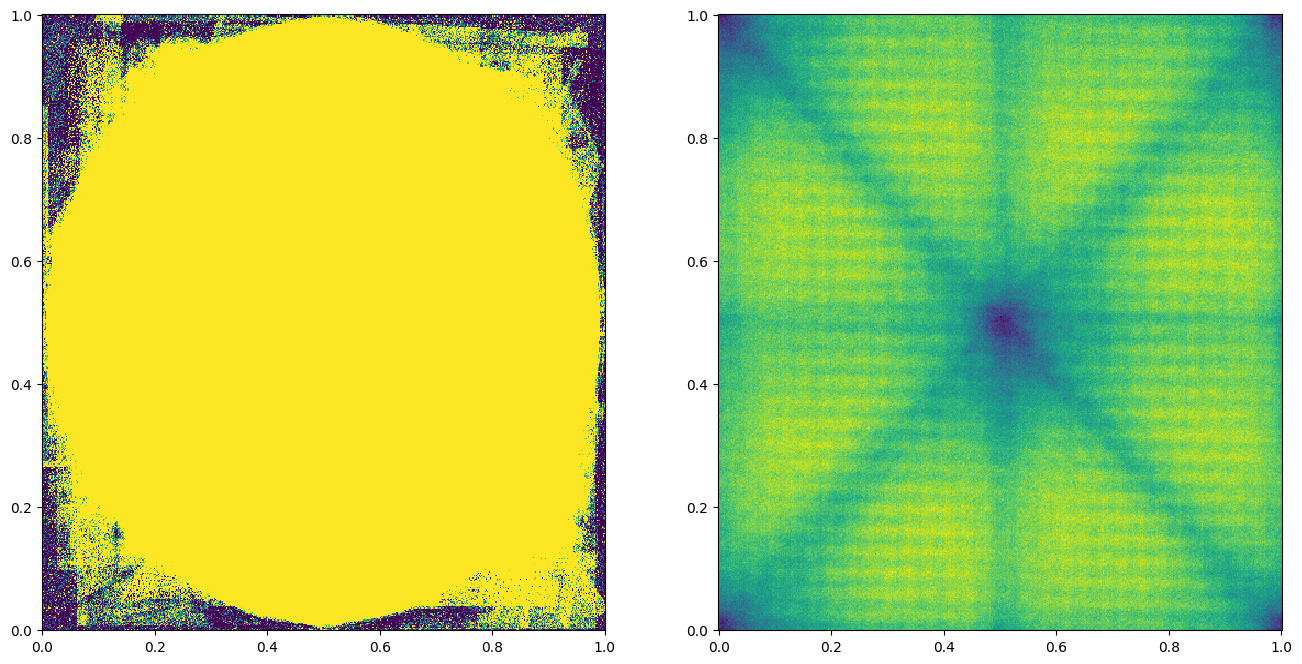

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(np.array(mask), ax=ax[0])
frame_plot(result, ax=ax[1])

In [ ]:
masks = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)
pics = []

In [ ]:
for i in range(masks.shape[0] // 2):
  pics.append(compute_atl(masks[i], p, p, wl, d_wl).get())

In [ ]:
for i in range(masks.shape[0] // 2, masks.shape[0]):
  pics.append(compute_atl(masks[i], p, p, wl, d_wl).get())

In [ ]:
np.save('/content/drive/MyDrive/simulations.npy', pics)